In [2]:
import pandas as pd 
import pywt
import numpy as np
from scipy.signal import correlate

In [3]:

df = pd.read_csv(r'C:\Users\shivk\cml1NILM\household_power_consumption.txt', delimiter=';', parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 na_values=['nan','?'])
df = df.dropna()
df['total_power'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df.rename(columns={'Sub_metering_1': 'Kitchen', 'Sub_metering_2': 'Laundry', 'Sub_metering_3': 'Heavy_Appliances'}, inplace=True)
reference = df['Kitchen'].iloc[1027:1057]
#please import path location according to system requrements. 

C:\Users\shivk\AppData\Local\Temp\ipykernel_23364\1044706094.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(r'C:\Users\shivk\cml1NILM\household_power_consumption.txt', delimiter=';', parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
C:\Users\shivk\AppData\Local\Temp\ipykernel_23364\1044706094.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(r'C:\Users\shivk\cml1NILM\household_power_consumption.txt', delimiter=';', parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,


In [43]:

wavelet = 'haar'
reference_coeffs = pywt.wavedec(reference, wavelet)
kitchen_coeffs = pywt.wavedec(df['Kitchen'], wavelet)
total_power_coeffs = pywt.wavedec(df['total_power'], wavelet)
print("REFERENCE \n")
print(reference_coeffs)
print("KITCHEN \n")
print(kitchen_coeffs[0:5] )
print("TOTAL POWER \n")
print(total_power_coeffs[0:5])


REFERENCE 

[array([112.25,  19.25]), array([-34.25,  14.75]), array([-48.7903679 ,  -1.06066017,  21.21320344,   0.35355339]), array([-2.5,  0.5, -0.5, -1. , 29. ,  0. ,  0.5,  0. ]), array([ 0.        , -3.53553391,  0.        , -0.70710678,  0.        ,
        0.70710678,  0.70710678, -0.70710678,  7.77817459, -0.70710678,
        0.        ,  0.        ,  0.70710678,  0.        ,  0.        ])]
KITCHEN 

[array([1205.83496094, 1076.42675781]), array([37.75878906, 62.55371094]), array([ 98.62482316,  92.24290825,  86.53219235, 129.39915989]), array([ -60.6171875 ,  -50.19921875,   -9.32617188,  -76.8359375 ,
         75.07226563, -121.81835938,   17.72851562, -101.2109375 ]), array([  17.321354  ,  -93.82699316,  -13.78858223,  -72.86514409,
         78.90317309,    2.32848053,  144.4376086 ,  -38.19481473,
        -21.79877624,   56.31718813, -101.10522117,  -23.33176164,
         43.52573695,  -95.39588634,  -50.50841641,   30.10175665])]
TOTAL POWER 

[array([8790.91992188, 9321

wavedec -> does a discrete transformation of data. 
here, these coefficients are the list of arrays for each  reference, kitchen and total power where each array contains the wavelet coefficients at different scales. Here scales can be used to represent the level of detail.

Performing cross correlation between the wavelet coefficients of the reference parrten and those of "KITCHEN" and "TOTAL POWER" time series. We do this at each scale, and then combine the results to obtain a measure of similarity between the reference pattern and the time series at each point in time. 
After doing this we will get a time series where each new value represents the similarity between the reference pattern and the "KITCHEN" and "TOTAL POWER" 

This is a time consuming function as you compare the reference pattern to every subsequence of the kitchen and total_power time series. The resulting time series will be longer than the original time series because this correlation function considers alignments of the reference attern that extend beyond the beginning and the end of the time series. We discard the places where the reference pattern extends beyond the time series. 

One problem that arises with this because the reference pattern has different scales, and the kitchen time series has more scales (this is because the kitchen is much longer than the reference pattern, hence there is more finer detail, hence more scales) 

To align the scales, we can truncate the wavelet coefficients of the kitchen time series, to the number of scales in the reference pattern. This will disregard the finest levels of details in the "KITCHEN" series. This will let us perform cross correlation. 
Correlate function returns an array whose length depends on the lengths of the input arrays, and these lengths can vary across different scales. So we calculate the length of the cross correlation series based on the longest cross correlation result. This way, we ensure that all the results can fit into the series without negative values. 

In [45]:
def cross_correlate_wavelet_coeffs(coeffs1, coeffs2):
    assert len(coeffs1) == len(coeffs2)
    length = max(len(correlate(c2, c1, mode='full')) for c1, c2 in zip(coeffs1, coeffs2))
    cross_correlation = np.zeros(length)
    for c1, c2 in zip(coeffs1, coeffs2):
        c = correlate(c2, c1, mode='full')
        padding = length - len(c)
        c = np.pad(c, (padding // 2, padding - padding // 2))
        cross_correlation += c
    return cross_correlation[len(coeffs1[0]) - 1 : -len(coeffs1[0]) + 1]


In [46]:
# Truncate the wavelet coefficients of the 'kitchen' time series to match the number of scales in the reference pattern
kitchen_coeffs_truncated = kitchen_coeffs[:len(reference_coeffs)]

# kitchen_cross_correlation = cross_correlate_wavelet_coeffs(reference_coeffs, kitchen_coeffs)
kitchen_cross_correlation = cross_correlate_wavelet_coeffs(reference_coeffs, kitchen_coeffs_truncated)

kitchen_cross_correlation

array([ 0.00000000e+00,  1.22480469e+01, -6.63457031e+01, -9.75000000e+00,
       -6.37714844e+01,  2.56867188e+02, -7.30654297e+02,  9.46914062e+01,
       -7.19005859e+02, -1.19047168e+03, -1.57222266e+03,  3.12029150e+03,
        2.29726313e+04,  1.55406555e+05,  1.13865484e+05, -4.40778369e+03,
       -9.45191113e+03,  2.53366211e+02, -9.56292969e+02, -3.32124023e+02,
        6.34763672e+02, -3.07068359e+02,  3.12253906e+02,  1.71230469e+02,
       -1.18171875e+02,  3.15990234e+02,  1.78574219e+02, -1.06425781e+02])

The resulting array represents the similarity between the reference pattern and the kitchen time series at each point in time. We then will try to identify the peaks in this array (peaks represent the points of high similarity between the reference pattern and the kitchen time series) This inturn tells us the places that this pattern can potentially occur. 

In [60]:

n = len(reference)
cross_correlation_values = []
for i in range(0, len(df['Kitchen']) - n, 15):
   
    window = df['Kitchen'].iloc[i : i+n]
    window_coeffs = pywt.wavedec(window, wavelet)
    cross_correlation = cross_correlate_wavelet_coeffs(reference_coeffs, window_coeffs)
    cross_correlation_values.append(np.max(cross_correlation))



In [68]:
cross_correlation_values_total_power = []
for i in range(0, len(df['total_power']) - n, 15):
    window = df['total_power'].iloc[i : i+n]
    window_coeffs = pywt.wavedec(window, wavelet)
    cross_correlation = cross_correlate_wavelet_coeffs(reference_coeffs, window_coeffs)
    cross_correlation_values_total_power.append(np.max(cross_correlation))


In [70]:
scale_factor_kitchen = max(df['Kitchen']) / max(cross_correlation_values)
scale_factor_total_power = max(df['total_power']) / max(cross_correlation_values_total_power)


C:\Users\shivk\AppData\Local\Temp\ipykernel_23364\40900376.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\shivk\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


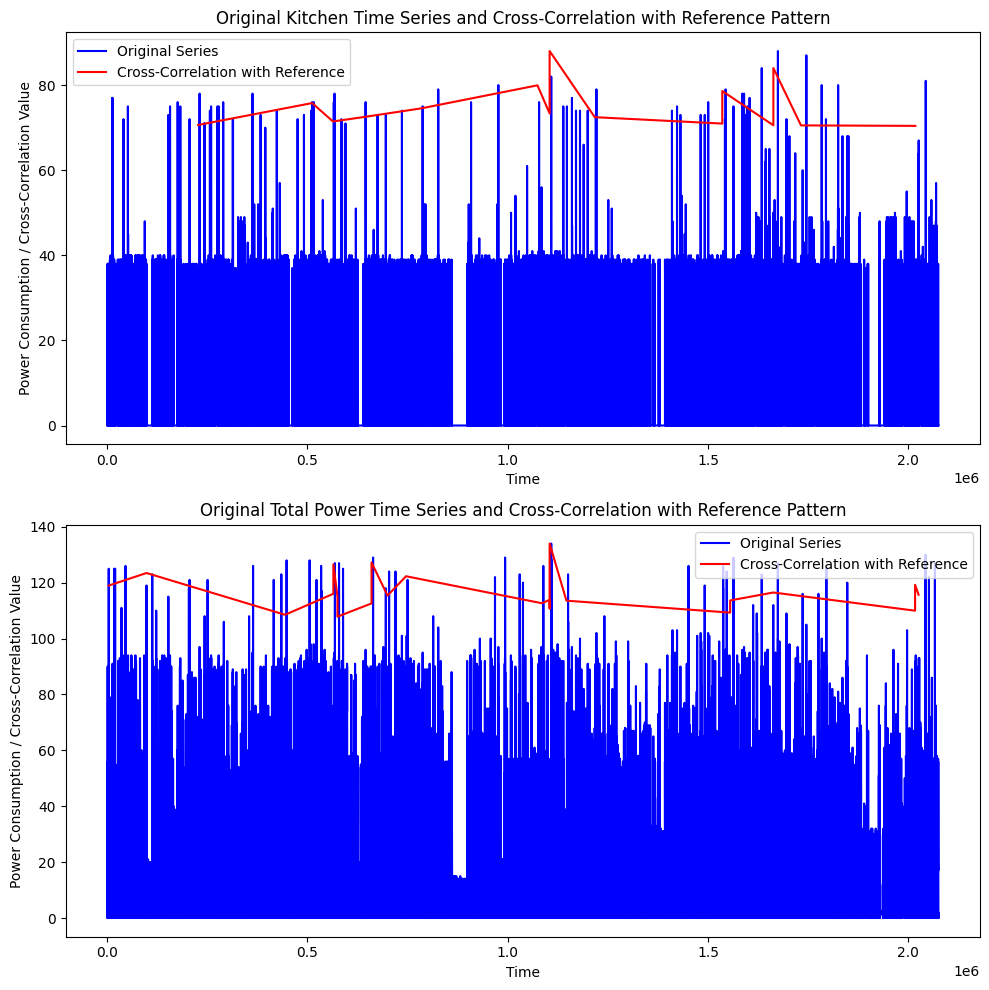

In [72]:
import matplotlib.pyplot as plt
# Convert the list of cross-correlation values to pandas Series
cross_correlation_series = pd.Series(cross_correlation_values)
cross_correlation_series_total_power = pd.Series(cross_correlation_values_total_power)

# Create masks for cross-correlation values that are greater than 80% of the maximum value
mask_kitchen = cross_correlation_series > 0.8 * cross_correlation_series.max()
mask_total_power = cross_correlation_series_total_power > 0.8 * cross_correlation_series_total_power.max()

# Create a new figure with two subplots
fig, axs = plt.subplots(2, figsize=(10, 10))

# Plot the original 'kitchen' time series and its cross-correlation values above 80%
axs[0].plot(df['Kitchen'].index, df['Kitchen'], color='blue', label='Original Series')
axs[0].plot(df['Kitchen'].index[:len(cross_correlation_series)][mask_kitchen] * 15, cross_correlation_series[mask_kitchen] * scale_factor_kitchen, color='red', label='Cross-Correlation with Reference')
axs[0].set_title('Original Kitchen Time Series and Cross-Correlation with Reference Pattern')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power Consumption / Cross-Correlation Value')
axs[0].legend()

# Plot the original 'total_power' time series and its cross-correlation values above 80%
axs[1].plot(df['total_power'].index, df['total_power'], color='blue', label='Original Series')
axs[1].plot(df['total_power'].index[:len(cross_correlation_series_total_power)][mask_total_power] * 15, cross_correlation_series_total_power[mask_total_power] * scale_factor_total_power, color='red', label='Cross-Correlation with Reference')
axs[1].set_title('Original Total Power Time Series and Cross-Correlation with Reference Pattern')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Power Consumption / Cross-Correlation Value')
axs[1].legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()




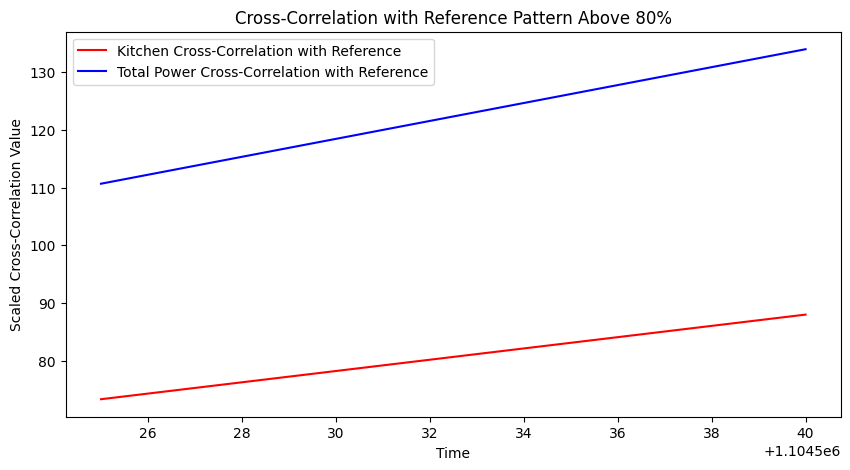

In [73]:
# Create a common mask that selects only the indices where both series are True
common_mask = mask_kitchen & mask_total_power

# Create a new figure
plt.figure(figsize=(10, 5))

# Plot the 'kitchen' cross-correlation values above 80%
plt.plot(df['Kitchen'].index[:len(cross_correlation_series)][common_mask] * 15, cross_correlation_series[common_mask] * scale_factor_kitchen, color='red', label='Kitchen Cross-Correlation with Reference')

# Plot the 'total_power' cross-correlation values above 80%
plt.plot(df['total_power'].index[:len(cross_correlation_series_total_power)][common_mask] * 15, cross_correlation_series_total_power[common_mask] * scale_factor_total_power, color='blue', label='Total Power Cross-Correlation with Reference')

# Add a title and labels
plt.title('Cross-Correlation with Reference Pattern Above 80%')
plt.xlabel('Time')
plt.ylabel('Scaled Cross-Correlation Value')
plt.legend()

# Display the plot
plt.show()


Observation:

The observation reveals a positive slope in both the cross-correlation values of the 'Kitchen' and 'Total Power' data series. The cross-correlation values exhibit a similar slope, indicating a consistent pattern of correlation with the reference signal over time for both series.

Inference:

Based on this observation, we can infer that there is a consistent and increasing similarity between the usage patterns of the kitchen and the overall household, compared to the reference pattern. The positive slope suggests that the correlation with the reference signal is growing over time for both 'Kitchen' and 'Total Power'. This indicates that the usage patterns in both areas are aligning more closely with the reference pattern as time progresses.

However, it's important to consider other factors that could influence these correlations. The observed positive slope and similarity in the cross-correlation values do not establish a causal relationship or identify specific factors driving the observed patterns. Further analysis and investigation are necessary to determine the underlying causes and fully interpret the implications of these findings.

Therefore, the inference drawn from this observation is that there is a positive slope in the cross-correlation values, suggesting an increasing alignment of the usage patterns of both the kitchen and the total household with the reference pattern over time.